In [25]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import random
import os
import os.path
import glob
import imutils
import warnings
import tensorflow as tf
print(tf.__version__)
warnings.filterwarnings('ignore')
plt.style.use('dark_background')
%matplotlib inline

2.0.0


In [4]:
#Extracting single letters from captcha

CAPTCHA_IMAGE_FOLDER = "train"
OUTPUT_FOLDER = "extracted_images"

# Get a list of all the captcha images we need to process
captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))
counts = {}

# loop over the image paths
for (i, captcha_image_file) in enumerate(captcha_image_files):
#     print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))
    
    # Since the filename contains the captcha text (i.e. "2A2X.png" has the text "2A2X"),
    # grab the base filename as the text
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]
    
    # Load the image
    image = cv2.imread(captcha_image_file)
    
    # ****************************************   MODIFICATION STARTED   *****************************************
#     print(captcha_correct_text)
#     print(len(captcha_correct_text))
    b_color = 255
    img = image
    np.transpose(img)[0] = np.transpose(img)[0] - img[0][0][0] + b_color
    np.transpose(img)[1] = np.transpose(img)[1] - img[0][0][1] + b_color
    np.transpose(img)[2] = np.transpose(img)[2] - img[0][0][2] + b_color
    
#     background = list(img[0][0])

#     for i in range(img.shape[0]):
#         for j in range(img.shape[1]):
#             if img[i][j][0] == background[0] and img[i][j][1] == background[1] and img[i][j][2] == background[2]:
#                 img[i][j][0] = 255
#                 img[i][j][1] = 255
#                 img[i][j][2] = 255


    
    kernel = np.ones((9,8), np.uint8) 
    img_dilation = cv2.dilate(img, kernel, iterations=2)
    img_erosion = cv2.erode(img_dilation, kernel, iterations=1) 
    image = img_erosion
    # ************************************    MODIFICATION ENDED   *************************************************
    
    # Convert it to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
#     plt.imshow(gray)
#     plt.show()


    #*************************** MODIFICATION *****************
    sigma = 0.33
    v = np.median(gray)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    # edged = cv2.Canny(gray, lower, upper)


    # threshold the image (convert it to pure black and white)
    thresh1 = cv2.threshold(gray, lower, upper, cv2.THRESH_BINARY_INV | cv2.THRESH_TRIANGLE)[1]

#     thresh = cv2.Canny(thresh1,lower,upper)
    thresh = thresh1
    #******************************   ENDED   ****************************
    
    # threshold the image (convert it to pure black and white)
#     thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
#     plt.imshow(thresh)
#     plt.show()
    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
    # Hack for compatibility with different OpenCV versions
    contours = contours[1] if imutils.is_cv3() else contours[0]

    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)
        
        
        #**********************   MODIFICATION BEGINS --- COMMENTED ALL BUT LAST  *****************************
#         # Compare the width and height of the contour to detect letters that
#         # are conjoined into one chunk
#         if w / h > 1.25:
#             # This contour is too wide to be a single letter!
#             # Split it in half into two letter regions!
#             half_width = int(w / 2)
#             letter_image_regions.append((x, y, half_width, h))
#             letter_image_regions.append((x + half_width, y, half_width, h))
#         else:
            # This is a normal letter by itself
        letter_image_regions.append((x, y, w, h))
    #*******************************************   MODIFICATION ENDS   *********************************************
    
    
    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    
     #**********   COMMENTED BELOW TWO LINES  ******************************
#     if len(letter_image_regions) != 4:
#         continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Save out each letter as a single image
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_correct_text):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 10-pixel margin around the edge
        letter_image = gray[y - 10:y + h + 10, x - 10:x + w + 10]

        # Get the folder to save the image in
        save_path = os.path.join(OUTPUT_FOLDER, letter_text)

        # if the output directory does not exist, create it
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)

        # increment the count for the current key
        counts[letter_text] = count + 1


In [5]:
import pickle
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Flatten, Dense
from helpers import resize_to_fit



In [6]:
#train model


LETTER_IMAGES_FOLDER = "extracted_images"
MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"


# initialize the data and labels
data = []
labels = []
count = 0
# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    if image is None:
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)
    
    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)
    
# #**********************************   ADDED    *************************
# X_train = tf.keras.utils.normalize(X_train,axis=1)
# X_test = tf.keras.utils.normalize(X_test,axis=1)
# #***********************************   END   ********************

# Build the neural network!
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(100, activation="relu"))

# Output layer with 26 nodes (one for each possible letter we predict)
model.add(Dense(26, activation="softmax"))

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

# Train the neural network
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10 , verbose=1)

# Save the trained model to disk
model.save(MODEL_FILENAME)


Train on 5256 samples, validate on 1752 samples
Epoch 1/10
5256/5256 [==============================] - 11s 2ms/sample - loss: 2.8912 - accuracy: 0.1726 - val_loss: 2.0487 - val_accuracy: 0.3739
Epoch 2/10
5256/5256 [==============================] - 6s 1ms/sample - loss: 1.2686 - accuracy: 0.6355 - val_loss: 0.8608 - val_accuracy: 0.7186
Epoch 3/10
5256/5256 [==============================] - 6s 1ms/sample - loss: 0.5085 - accuracy: 0.8642 - val_loss: 0.4176 - val_accuracy: 0.8465
Epoch 4/10
5256/5256 [==============================] - 7s 1ms/sample - loss: 0.2375 - accuracy: 0.9422 - val_loss: 0.1917 - val_accuracy: 0.9475
Epoch 5/10
5256/5256 [==============================] - 7s 1ms/sample - loss: 0.1379 - accuracy: 0.9709 - val_loss: 0.1194 - val_accuracy: 0.9669
Epoch 6/10
5256/5256 [==============================] - 6s 1ms/sample - loss: 0.0892 - accuracy: 0.9798 - val_loss: 0.0699 - val_accuracy: 0.9834
Epoch 7/10
5256/5256 [==============================] - 7s 1ms/sample - los

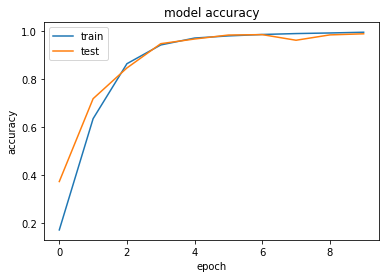

In [13]:
#Model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

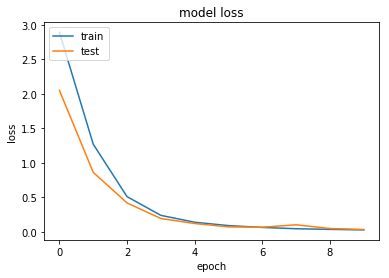

In [14]:
#Model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

TESTING PHASE

Number of characters in the image:  4
CAPTCHA text is: KRXQ


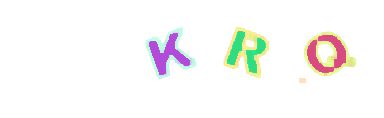

In [26]:
from tensorflow.keras.models import load_model

MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"
CAPTCHA_IMAGE_FOLDER = "train"


# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model(MODEL_FILENAME)

# Grab some random CAPTCHA images to test against.
# In the real world, you'd replace this section with code to grab a real
# CAPTCHA image from a live website.
captcha_image_files = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
captcha_image_files = np.random.choice(captcha_image_files, size=(1,), replace=False)

# loop over the image paths
for image_file in captcha_image_files:
    # Load the image and convert it to grayscale
#     image = cv2.imread(image_file)
    image = cv2.imread('train/KRQ.png')
    if image is None:
            continue
    # ****************************************   MODIFICATION STARTED   *****************************************
#     print(captcha_correct_text)
#     print(len(captcha_correct_text))
    b_color = 255
    img = image
    np.transpose(img)[0] = np.transpose(img)[0] - img[0][0][0] + b_color
    np.transpose(img)[1] = np.transpose(img)[1] - img[0][0][1] + b_color
    np.transpose(img)[2] = np.transpose(img)[2] - img[0][0][2] + b_color
    
#     background = list(img[0][0])

#     for i in range(img.shape[0]):
#         for j in range(img.shape[1]):
#             if img[i][j][0] == background[0] and img[i][j][1] == background[1] and img[i][j][2] == background[2]:
#                 img[i][j][0] = 255
#                 img[i][j][1] = 255
#                 img[i][j][2] = 255

    
    kernel = np.ones((8,6), np.uint8) 
    img_dilation = cv2.dilate(img, kernel, iterations=2)
    img_erosion = cv2.erode(img_dilation, kernel, iterations=1) 
    image = img_erosion
    # ************************************    MODIFICATION ENDED   *************************************************
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 20, 20, 20, 20, cv2.BORDER_REPLICATE)
#     print(type(image[0]))


    #*************************** MODIFICATION *****************
    sigma = 0.33
    v = np.median(gray)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    # edged = cv2.Canny(gray, lower, upper)

    
    # threshold the image (convert it to pure black and white)
    thresh1 = cv2.threshold(gray, lower, upper, cv2.THRESH_BINARY_INV | cv2.THRESH_TRIANGLE)[1]

#     thresh = cv2.Canny(thresh1,lower,upper)
    thresh = thresh1
    #******************************   ENDED   ****************************
    
    # threshold the image (convert it to pure black and white)
#     thresh = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    contours = contours[1] if imutils.is_cv3() else contours[0]

    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
#         if w / h > 1.25:
#             # This contour is too wide to be a single letter!
#             # Split it in half into two letter regions!
#             half_width = int(w / 2)
#             letter_image_regions.append((x, y, half_width, h))
#             letter_image_regions.append((x + half_width, y, half_width, h))
#         else:
#             # This is a normal letter by itself
        letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
#     if len(letter_image_regions) != 4:
#         continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    print("Number of characters in the image: ",len(letter_image_regions))
    
    # Create an output image and a list to hold our predicted letters
    output = cv2.merge([image] * 3)
    predictions = []

    # loop over the lektters
    for letter_bounding_box in letter_image_regions:
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 10:y + h + 10, x - 10:x + w + 10]
        
        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = resize_to_fit(letter_image, 20, 20)
#         plt.imshow(letter_image)
#         plt.show()
        
        # Turn the single image into a 4d list of images to make Keras happy
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)
        letter_image = tf.cast(letter_image, tf.float32)
        
        # Ask the neural network to make a prediction
        prediction = model.predict(letter_image,steps=1)
#         print(prediction)
        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

       
    #     draw the prediction on the output image
#         cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
#         cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

    # Print the captcha's text
    captcha_text = "".join(predictions)
    print("CAPTCHA text is: {}".format(captcha_text))

    # Show the annotated image
    plt.imshow(image)
    plt.show()
#     cv2.waitKey()